In [1]:
# conda create -n siamese_env python=3.10 3.11?
# conda activate siamese_env

# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# conda install numpy pandas -y
# conda install pillow -y
# conda install matplotlib -y
# conda install seaborn -y
# conda install opencv -y

# pip install supervision
# conda install jupyter -y

############################################################## это не надо! 
# conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# pip install tensorflow-gpu==2.10.0 --user
# conda install tensorflow -y (версия 2.10)
# conda install keras -y

In [1]:
import torch
print(torch.__version__)

2.6.0+cu124


In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available: True
CUDA version: 12.4
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4090


In [3]:
# Установка библиотек 

import pandas as pd
import numpy as np
import os
from PIL import Image

import matplotlib.pyplot as plt

import seaborn as sns
import cv2
import supervision as sv

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

HOME = os.getcwd()

In [4]:
N1=219 # изначальное количество изображений base 2304x1296
N2=283 # количество изображений base 3840x2160
N=N1+N2  # финальное количество изображений base 2304x1296 

M1=340 # количество изображений common 3730x2098
M2=162 # количество изображений common 4590x2582
M=M1+M2 # финальное количество изображений common 2304x1296 

S1=340 # количество изображений opp 3730x2098
S2=162 # количество изображений opp 4590x2582
S=S1+S2 # финальное количество изображений opp 2304x1296 
margin=1

In [5]:
# Функция изменения разрешения изображений

import PIL

def change_resolution(directory,directory_,K,width,height):
    count=0
    
    for filename in os.listdir(directory):
        if count>=K:
            break
        image_path = os.path.join(directory,filename)
        
        img = Image.open(image_path)
        resized_img = img.resize((width, height), PIL.Image.Resampling.LANCZOS)
    
        destination_directory1=os.path.join(directory_,filename)
    
        resized_img.save(destination_directory1)
        count+=1

In [6]:
# Функция считывание изображений из папки 

from os import listdir

def load_images_from_folder(directory,L):
    images=[]
    count=0
    
    for filename in os.listdir(directory):
        if count>=L:
            break
        image_path = os.path.join(directory,filename)
        
        img=cv2.imread(image_path)
        
        images.append(img)
        count+=1
        
    return np.array(images)

In [15]:
# Текущая директория

import os
HOME = os.getcwd()

directory7_='/wrk/data/processed/base-20250128T085319Z-001/base/Sort1/640x640' 

directory8_='/wrk/data/processed/common-20250128T085141Z-001/common/Sort1/640x640'

directory9_='/wrk/data/processed/opp-20250128T084818Z-001/opp/Sort1/640x640'

width1 = 640
height1 = 640

In [12]:
input_shape=(width1, height1, 3)

In [13]:
# Создание меток для пар, 0 - для похожих, 1 - для непохожих

Y_common_pairs=np.zeros([M,1])

Y_opposite_pairs=np.ones([S,1])

In [16]:
im_base_resh=load_images_from_folder(directory7_,N)

im_common_resh=load_images_from_folder(directory8_,M)

im_opposite_resh=load_images_from_folder(directory9_,S)

In [17]:
trans=transforms.Compose([transforms.ToTensor()])


In [18]:
import torch
im_common_resh_tor = torch.stack([trans(img) for img in im_common_resh])
im_base_resh_tor = torch.stack([trans(img) for img in im_base_resh])
im_opposite_resh_tor = torch.stack([trans(img) for img in im_opposite_resh])

In [19]:
data_pairs_train_com = [(im_base_resh_tor[i,:,:,:].float(), im_common_resh_tor[i,:,:,:].float()) for i in range(350)]

In [20]:
data_pairs_train_opp = [(im_base_resh_tor[i,:,:,:].float(), im_opposite_resh_tor[i,:,:,:].float()) for i in range(350)]

In [21]:
data_pairs_train_com.extend(data_pairs_train_opp)

In [22]:
#Создание соответствующих меток
y_train_pairs = np.vstack([Y_common_pairs[0:350,:],Y_opposite_pairs[0:350,:]])
y_test_pairs = np.vstack([Y_common_pairs[351:502,:],Y_opposite_pairs[351:502,:]])


In [23]:
labels_train = torch.from_numpy(y_train_pairs)

In [24]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Определяем слои сети
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)) # 319x319
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) # 159x159
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)) # 79x79
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) # 39x39
        
        self.flattened_size=self._get_flattened_size(width1,height1)
        
        self.fc=nn.Linear(self.flattened_size,128)
        
        # self.flatten = nn.Flatten()
        # # self.dropout = nn.Dropout(0.5)
        
        # self.fc = nn.Linear(64 * 39 * 39, 128)  # Учитываем изменение размерности после сверток и пулинга
        
    def _get_flattened_size(self, width,height):
        x=torch.zeros(1,3,width,height)
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        return x.numel()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = torch.flatten(x,start_dim=1)
        x = F.dropout(x,p=0.5)
        x = F.relu(self.fc(x))
        
        return x

    def euclidean_distance(self, output1, output2):
        return torch.sqrt(torch.sum((output1 - output2) ** 2, dim=1))

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
siamese = SiameseNetwork().to(device)

In [27]:
batch_size=64

In [28]:
class ContrastiveLoss(nn.Module):
    def __init__(self,margin=1):
        super(ContrastiveLoss,self).__init__()
        self.margin=margin
        
    def forward (self,output1,output2,label):
        distance=torch.sqrt(torch.sum((output1-output2)**2,dim=1))
        loss=(1-label)*torch.pow(distance,2)+(label)*torch.pow(torch.clamp(self.margin-distance,min=0.0),2)
        return torch.mean(loss)

In [29]:
class SiameseDataset(Dataset):
    def __init__(self, data_pairs, labels):
        self.data_pairs = data_pairs  # Список пар изображений
        self.labels = labels  # Список меток (0 или 1)

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        img1, img2=self.data_pairs[idx]
        label=self.labels[idx]
        
        img1=img1.float()
        img2=img2.float()
        
        return (img1,img2), label

In [30]:
dataset_train = SiameseDataset(data_pairs_train_com, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


In [31]:
criterion = ContrastiveLoss(margin=1.0)  # nn.BCEWithLogitsLoss

In [32]:
optimizer = optim.Adam(siamese.parameters(), lr=0.001)

In [33]:
num_epochs = 15
loss_values =[]
accuracy_values=[]

In [34]:
# ОБУЧЕНИЕ

for epoch in range(num_epochs):
    epoch_loss = 0 # суммарная потеря за эпоху
    correct_predictions= 0 # колличество правильных предсказаний
    total_predictions = 0 # общее колличество предсказаний
    
    for batch_idx, (data_pair, label) in enumerate(dataloader_train):
        input_1, input_2 = data_pair[0].to(device), data_pair[1].to(device)
        
        if isinstance(label,list):
            label = torch.tensor(label)
            
        label=label.float().to(device).view(-1)
        # label = [lbl.to(device).view for lbl in label] 
        
        optimizer.zero_grad()

        # Прямой проход через модель
        output1 = siamese(input_1)
        output2 = siamese(input_2)

        # Вычисление потерь
        loss = criterion(output1,output2, label)
        
      
        # Обратный проход и обновление параметров
        loss.backward()
        optimizer.step()
        
        epoch_loss+=loss.item() # Суммируем потери
        
        if batch_idx % 2 == 0:  # Печатаем каждые 2 итерации
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(dataloader_train)}], Loss: {loss.item():.4f}')
            
        distance = siamese.euclidean_distance(output1,output2) 
        predictions = (distance>0.5).float()  
        correct_predictions +=(predictions == label).sum().item() #+= torch.sum(predictions == label) 
        total_predictions+= len(label)                        
    
    avg_epoch_loss=epoch_loss/len(dataloader_train)
    accuracy = correct_predictions/total_predictions
        
    loss_values.append(avg_epoch_loss)
    accuracy_values.append(accuracy)
    
    
    # torch.cuda.empty_cache()
        
    print(f'Epoch {epoch}, Loss:{avg_epoch_loss}, Accuracy: {accuracy}')
 
print("Обучение завершено")


Epoch [1/15], Step [0/11], Loss: 0.2820
Epoch [1/15], Step [2/11], Loss: 64.8367
Epoch [1/15], Step [4/11], Loss: 5.1638
Epoch [1/15], Step [6/11], Loss: 4.2286
Epoch [1/15], Step [8/11], Loss: 1.8085
Epoch [1/15], Step [10/11], Loss: 0.7893
Epoch 0, Loss:17.764443294568494, Accuracy: 0.5014285714285714
Epoch [2/15], Step [0/11], Loss: 0.6056
Epoch [2/15], Step [2/11], Loss: 0.4821
Epoch [2/15], Step [4/11], Loss: 0.3975
Epoch [2/15], Step [6/11], Loss: 0.2875
Epoch [2/15], Step [8/11], Loss: 0.2444
Epoch [2/15], Step [10/11], Loss: 0.2687
Epoch 1, Loss:0.358032378283414, Accuracy: 0.5342857142857143
Epoch [3/15], Step [0/11], Loss: 0.3373
Epoch [3/15], Step [2/11], Loss: 0.2493
Epoch [3/15], Step [4/11], Loss: 0.2880
Epoch [3/15], Step [6/11], Loss: 0.2765
Epoch [3/15], Step [8/11], Loss: 0.2550
Epoch [3/15], Step [10/11], Loss: 0.2804
Epoch 2, Loss:0.27489065717567096, Accuracy: 0.5471428571428572
Epoch [4/15], Step [0/11], Loss: 0.2903
Epoch [4/15], Step [2/11], Loss: 0.2414
Epoch [

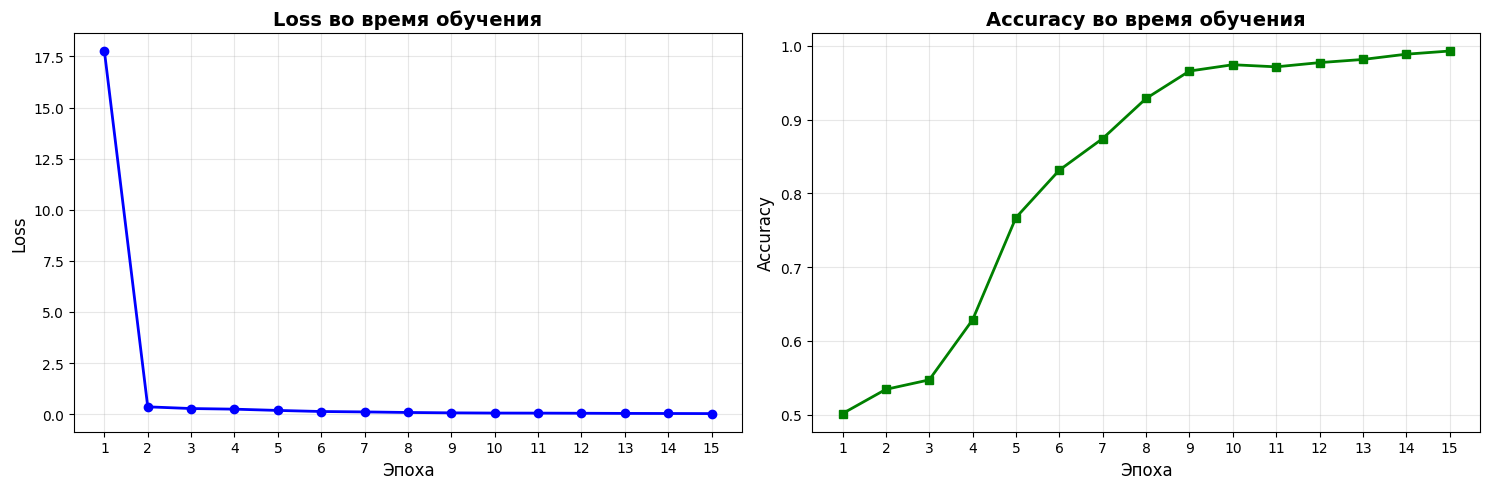


Финальные результаты обучения:
Финальный Loss: 0.0275
Финальная Accuracy: 0.9929
Лучшая Accuracy: 0.9929


In [37]:
# Графики loss и accuracy по эпохам
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_values, 'b-', linewidth=2, marker='o')
plt.title('Loss во время обучения', fontsize=14, fontweight='bold')
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, num_epochs + 1))

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_values, 'g-', linewidth=2, marker='s')
plt.title('Accuracy во время обучения', fontsize=14, fontweight='bold')
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, num_epochs + 1))

plt.tight_layout()
plt.show()

# Вывод финальных значений
print(f'\nФинальные результаты обучения:')
print(f'Финальный Loss: {loss_values[-1]:.4f}')
print(f'Финальная Accuracy: {accuracy_values[-1]:.4f}')
print(f'Лучшая Accuracy: {max(accuracy_values):.4f}')

In [38]:
# ТЕСТИРОВАНИЕ
labels_test = torch.from_numpy(y_test_pairs)

In [39]:
data_pairs_test_com = [(im_base_resh_tor[i,:,:,:].float(), im_common_resh_tor[i,:,:,:].float()) for i in range(351,502)]

In [40]:
data_pairs_test_opp = [(im_base_resh_tor[i,:,:,:].float(), im_opposite_resh_tor[i,:,:,:].float()) for i in range(351,502)]

In [41]:
data_pairs_test_com.extend(data_pairs_test_opp)

In [42]:
dataset_test = SiameseDataset(data_pairs_test_com, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [43]:
siamese.eval()

SiameseNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1597696, out_features=128, bias=True)
)

In [44]:
test_loss=0
test_correct_predictions=0
test_total_predictions=0

In [47]:
with torch.no_grad():
    for data_pair,label in dataloader_test:
        
        input_1, input_2 = data_pair[0].to(device), data_pair[1].to(device)
        
        if isinstance(label,list):
            label = torch.tensor(label)
            
        label=label.float().to(device).view(-1)
        
        output1 = siamese(input_1)
        output2 = siamese(input_2)

        # Вычисление потерь
        loss = criterion(output1,output2, label)
        
      
        # Обратный проход и обновление параметров
       
        test_loss+=loss.item() # Суммируем потери
        
        distance = siamese.euclidean_distance(output1,output2) 
        test_predictions = (distance>0.5).float()  
        test_correct_predictions +=(test_predictions == label).sum().item() #+= torch.sum(predictions == label) 
        test_total_predictions+= len(label)                        
    
avg_test_loss=test_loss/len(dataloader_test)
test_accuracy = test_correct_predictions/test_total_predictions
        
  
print(f'Test loss {avg_test_loss}, Test Accuracy: {test_accuracy}')
 
print("Тестирование завершено")

Test loss 0.13760339990258216, Test Accuracy: 0.9403973509933775
Тестирование завершено


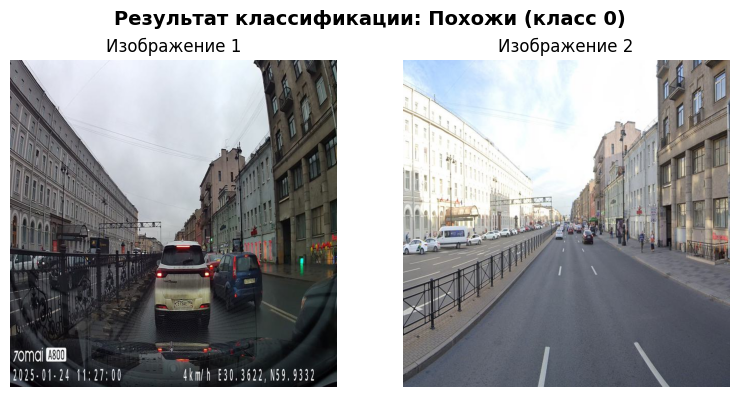

Истинная метка: 0
Предсказание: Похожи (класс 0)


In [81]:
# Визуализация пары изображений из тестовой выборки и вывод результата классификации

# Получим одну пару из тестового датасета
(img1, img2), label = dataset_test[s]  

# # Переведём изображения в numpy для отображения
img1_np = img1.permute(1, 2, 0).cpu().numpy()
img2_np = img2.permute(1, 2, 0).cpu().numpy()

img1_rgb = img1_np[:,:,::-1]
img2_rgb = img2_np[:,:,::-1]

# # Получим предсказание модели
# siamese.eval()
# with torch.no_grad():
#     out1 = siamese(img1.unsqueeze(0).to(device))
#     out2 = siamese(img2.unsqueeze(0).to(device))
#     distance = siamese.euclidean_distance(out1, out2)
#     prediction = (distance > 0.5).float().item()

# Текстовое описание результата
if predictions[s] == 0.0:
    result_text = "Похожи (класс 0)"
else:
    result_text = "Не похожи (класс 1)"

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img1_rgb)
axes[0].set_title("Изображение 1")
axes[0].axis('off')
axes[1].imshow(img2_rgb)
axes[1].set_title("Изображение 2")
axes[1].axis('off')
plt.suptitle(f"Результат классификации: {result_text}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Истинная метка: {int(label[s])}")
print(f"Предсказание: {result_text}")